<a href="https://colab.research.google.com/github/Sruva9/Vipplav_Projects/blob/main/PLDD_WBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Oct 28 17:51:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir="/content/drive/MyDrive/WBC-dataset"

In [4]:
import os
from torchvision import datasets, transforms
import wandb
from PIL import Image
import numpy as np
import cv2
import random, time
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms, models
from torch.cuda.amp import autocast, GradScaler

In [5]:
import torch

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"Num GPUs Available: {num_gpus}")

    # In PyTorch, memory growth (dynamic allocation) happens by default.
    # If you want to empty cached memory manually:
    torch.cuda.empty_cache()
else:
    print("No GPU available, using CPU instead.")

GPU 0: Tesla T4
Num GPUs Available: 1


In [6]:
wandb.login(key="b9591e975a5ad0ed213eb8314c067d4fff3ce87c")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sruva9 (sruva9-nextwealth) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
data_dir

'/content/drive/MyDrive/WBC-dataset'

In [8]:
from torchvision import datasets, transforms

dataset = datasets.ImageFolder(root=data_dir, transform=transforms.ToTensor())
print("Number of samples:", len(dataset))

Number of samples: 17093


In [9]:
Image_size = 128
Batch_size = 8

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define transformations (similar to image_size and normalization)
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    #transforms.ColorJitter(brightness=0.4, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Define a function to check for valid image files and exclude hidden files
def is_valid_image(path):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    return os.path.splitext(path)[1].lower() in valid_extensions and not os.path.basename(path).startswith('.')

# Load dataset from directory, filtering out non-image files
data = datasets.ImageFolder(root=data_dir, is_valid_file=is_valid_image, transform=transform)


# Create DataLoader for batching and shuffling
data_loader = DataLoader(data, batch_size=Batch_size, shuffle=True)

In [11]:
classes = data.classes
print(classes)
num_classes = len(classes)
print("Num classes:", num_classes)

['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Num classes: 8


In [14]:
for image_batch, label_batch in data_loader:
    print(image_batch.shape)
    print(label_batch)
    break  # take(1) equivalent → stop after first batch

torch.Size([8, 3, 224, 224])
tensor([7, 7, 5, 1, 1, 1, 7, 0])


In [15]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device)
    img_tensor = img_tensor * std[:, None, None] + mean[:, None, None]
    return img_tensor.clamp(0, 1)


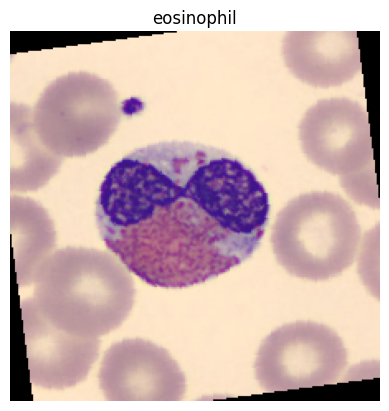

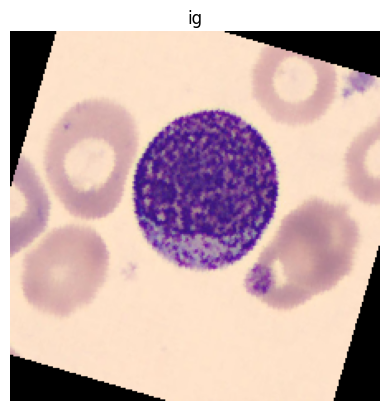

In [16]:
import matplotlib.pyplot as plt

# Take one batch from the DataLoader
for image_batch, label_batch in data_loader:
    for x in range(2):
        img_tensor = image_batch[x] # get the image tensor
        img_denormalized = denormalize(img_tensor)  # denormalize the image tensor
        img = img_denormalized.permute(1, 2, 0).numpy()  # convert from (C,H,W) → (H,W,C) and to numpy
        plt.imshow(img)
        plt.title(classes[label_batch[x]])
        plt.axis('off')
        plt.show()
    break  # only take the first batch

In [17]:
#EnhanceIfPoorQuality

class EnhanceIfPoorQuality(object):
    """
    Enhances low-quality images based on sharpness, brightness, and contrast.
    PIL in → PIL out
    """
    def __init__(self, blur_thresh=100.0, denoise_h=10, clahe_clip=2.0, sharpen=True,
                 auto_brightness=True, gamma_corr=True, color_balance=True, edge_enhance=True):
        self.blur_thresh = float(blur_thresh)
        self.denoise_h = denoise_h
        self.clahe_clip = clahe_clip
        self.sharpen = sharpen
        self.auto_brightness = auto_brightness
        self.gamma_corr = gamma_corr
        self.color_balance = color_balance
        self.edge_enhance = edge_enhance

    def __call__(self, pil_img: Image.Image):
        img = np.array(pil_img)
        if img.ndim == 2:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        else:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        blur_var = cv2.Laplacian(gray, cv2.CV_64F).var()

        # Skip enhancement if sharpness is already good
        if blur_var >= self.blur_thresh:
            out = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            return Image.fromarray(out)

        # 1️⃣ Denoise
        img_proc = cv2.fastNlMeansDenoisingColored(img_bgr, None, self.denoise_h, self.denoise_h, 7, 21)

        # 2️⃣ Adaptive brightness + contrast
        if self.auto_brightness:
            lab = cv2.cvtColor(img_proc, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=self.clahe_clip, tileGridSize=(8,8))
            l2 = clahe.apply(l)
            img_proc = cv2.merge((l2, a, b))
            img_proc = cv2.cvtColor(img_proc, cv2.COLOR_LAB2BGR)

        # 3️⃣ Gamma correction (for dim or overexposed lighting)
        if self.gamma_corr:
            gray_mean = np.mean(cv2.cvtColor(img_proc, cv2.COLOR_BGR2GRAY))
            gamma = 1.0 if gray_mean > 120 else 1.5 if gray_mean < 70 else 1.2
            inv_gamma = 1.0 / gamma
            table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
            img_proc = cv2.LUT(img_proc, table)

        # 4️⃣ Color balance (simple white balance approximation)
        if self.color_balance:
            result = cv2.cvtColor(img_proc, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(result)
            l = cv2.equalizeHist(l)
            result = cv2.merge((l, a, b))
            img_proc = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)

        # 5️⃣ Sharpening filter
        if self.sharpen:
            kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)
            img_proc = cv2.filter2D(img_proc, -1, kernel)

        # 6️⃣ Edge enhancement (boost visible texture)
        if self.edge_enhance:
            edges = cv2.Canny(cv2.cvtColor(img_proc, cv2.COLOR_BGR2GRAY), 50, 150)
            edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
            img_proc = cv2.addWeighted(img_proc, 0.9, edges_colored, 0.1, 0)

        # Convert back to RGB PIL Image
        out = cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB)
        return Image.fromarray(out)

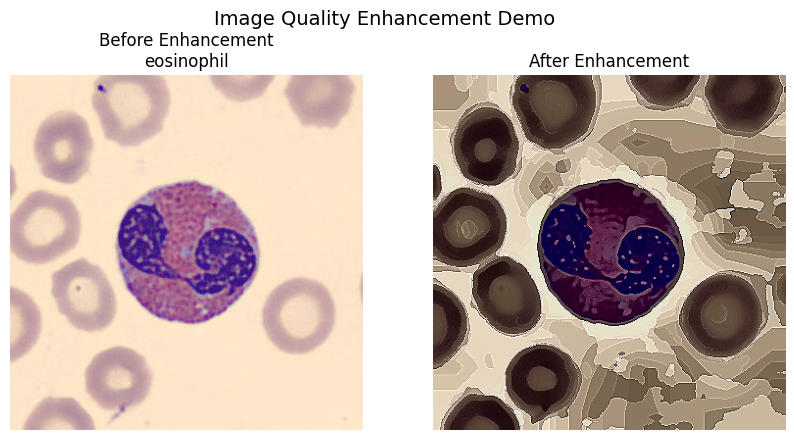

 Displayed image: /content/drive/MyDrive/WBC-dataset/eosinophil/EO_603195.jpg


In [18]:
# Test and visualize EnhanceIfPoorQuality on a random dataset image

import os, random
import matplotlib.pyplot as plt
from PIL import Image

# Set your dataset path (update this if your structure is different)
dataset_dir = data_dir

# Pick a random class folder and random image inside it
random_class = random.choice(os.listdir(dataset_dir))
class_path = os.path.join(dataset_dir, random_class)
random_img_path = os.path.join(class_path, random.choice(os.listdir(class_path)))

# Load image
img = Image.open(random_img_path).convert("RGB")

# Apply enhancement
enhancer = EnhanceIfPoorQuality(blur_thresh=100.0)
enhanced_img = enhancer(img)

# Display both images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Before Enhancement\n{random_class}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(enhanced_img)
plt.title("After Enhancement")
plt.axis("off")

plt.suptitle("Image Quality Enhancement Demo", fontsize=14)
plt.show()

print(f" Displayed image: {random_img_path}")

In [19]:
print("Total batches:", len(data_loader))
print("Total images:", len(data_loader.dataset))

Total batches: 2137
Total images: 17092


In [20]:
!ls -1 "$data_dir"

basophil
eosinophil
erythroblast
ig
lymphocyte
monocyte
neutrophil
platelet


In [21]:
from torch.utils.data import random_split

# Get total size
total_size = len(data)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size  # ensures total sums correctly

# Split dataset using the filtered 'data' object
train_ds, val_ds, test_ds = random_split(data, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=Batch_size, shuffle=True,num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=Batch_size, shuffle=False,num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=Batch_size, shuffle=False,num_workers=2, pin_memory=True)

In [22]:
print(f"Dataset split -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Dataset split -> Train: 11964, Val: 3418, Test: 1710


In [23]:
from torch.utils.data import DataLoader

# DataLoaders with caching-like behavior, shuffling, and prefetching
train_loader = DataLoader(
    train_ds,
    batch_size=Batch_size,
    shuffle=True,          # same as .shuffle(1000)
    num_workers=2,         # prefetching via parallel workers
    prefetch_factor=2,     # how many batches each worker preloads
    pin_memory=True        # speeds up GPU transfers
)

val_loader = DataLoader(
    val_ds,
    batch_size=Batch_size,
    shuffle=False,
    num_workers=2,
    prefetch_factor=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=Batch_size,
    shuffle=False,
    num_workers=2,
    prefetch_factor=2,
    pin_memory=True
)


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

# Using pretrained Resnet50 as backbone
#model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze base to speed up training
#for param in model.parameters():
    #param.requires_grad = False

# Unfreeze last block for fine-tuning
#for name, param in model.named_parameters():
    #if "layer4" in name or "fc" in name:
     #   param.requires_grad = True

#    elif "layer3" in name or "layer4" in name or "fc" in name:
#        param.requires_grad = True
 #   else:
  #      param.requires_grad = False


#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# Replace classifier head
#num_classes = len(classes)
#model.fc = nn.Linear(model.fc.in_features, num_classes)
#model.fc = nn.Sequential(
 #   nn.Dropout(0.3),
  #  nn.Linear(model.fc.in_features, num_classes)
#)

#model = model.to(device)


# Define learning rate
#learning_rate = 0.001

# Define loss function and optimizer
#criterion = nn.CrossEntropyLoss()              # same as 'sparse_categorical_crossentropy'
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ResNet50(nn.Module):
    def __init__(self, num_classes=8, image_size=128):
        super(ResNet50, self).__init__()

        # 1️⃣ Load pretrained ResNet50 backbone
        base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # 2️⃣ Remove the top FC layer
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])


        # 3️⃣ Freeze everything first
        for param in self.base_model.parameters():
            param.requires_grad = False

        # 4️⃣ Unfreeze specific blocks (fine-tuning layer3, layer4)
        for name, param in self.base_model.named_parameters():
             if "layer3" in name or "layer4" in name:
                param.requires_grad = True


        # 5️⃣ Add your custom convolutional block
        self.conv_block = nn.Sequential(
            nn.Conv2d(2048, 16, kernel_size=1),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, kernel_size=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=1),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # 6️⃣ Dynamically calculate flatten size
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, image_size, image_size)
            x = self.base_model(dummy_input)
            x = self.conv_block(x)
            flattened_size = x.view(x.size(0), -1).size(1)


        # 7️⃣ Flatten layer
        self.flatten = nn.Flatten()

        # 8️⃣ Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, 1024),  # Use dynamically calculated size
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.conv_block(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return F.softmax(x, dim=1)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
# Replace classifier head
#num_classes = len(classes)
base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)
base_model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(base_model.fc.in_features, num_classes) # And here
)

model = base_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


In [28]:
model = ResNet50(num_classes=len(classes), image_size=Image_size).to(device)
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

In [29]:
!pip install torchinfo

In [30]:
from torchinfo import summary

summary(model, input_size=(1, 3, Image_size, Image_size))

Layer (type:depth-idx)                        Output Shape              Param #
ResNet50                                      [1, 8]                    --
├─Sequential: 1-1                             [1, 2048, 4, 4]           --
│    └─Conv2d: 2-1                            [1, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 64, 64]           (128)
│    └─ReLU: 2-3                              [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                         [1, 64, 32, 32]           --
│    └─Sequential: 2-5                        [1, 256, 32, 32]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 32, 32]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 32, 32]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 32, 32]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 16, 16]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 16, 16]       

In [31]:
import torch

class MyCallback:
    def __init__(self, target_acc=0.98):
        self.target_acc = target_acc
        self.stop_training = False

    def check_accuracy(self, epoch, accuracy):
        if accuracy > self.target_acc:
            print(f"\nReached {self.target_acc*100:.0f}% accuracy at epoch {epoch+1}, stopping training!")
            self.stop_training = True

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DataLoaders using the filtered 'data' object
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,num_workers=2,
                          pin_memory=torch.cuda.is_available())

val_loader = DataLoader(val_ds, batch_size=8, shuffle=False,num_workers=2,
                        pin_memory=torch.cuda.is_available())

In [33]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

#optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5,
    weight_decay=1e-4
)

In [34]:
#from torch import amp
#scaler = amp.GradScaler("cuda")

#with amp.autocast("cuda"):
 #   outputs = model(image_batch)
  #  loss = criterion(outputs, label_batch)

In [35]:
from torch.optim.lr_scheduler import CosineAnnealingLR

scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

In [36]:
# Sanity check: Can the DataLoader produce one batch?
print("Testing DataLoader...")
batch = next(iter(train_loader))
print("Batch loaded:", batch[0].shape, batch[1].shape)

Testing DataLoader...
Batch loaded: torch.Size([8, 3, 224, 224]) torch.Size([8])


In [37]:
print("Device:", device)
print("Model device:", next(model.parameters()).device)

Device: cuda
Model device: cuda:0


In [38]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

CUDA available: True
Current device: cuda


In [39]:
num_classes = len(data.classes)
print("Classes:", num_classes)

Classes: 8


In [40]:
wandb.init(
    project="wbc",  # choose a project name
    config={
        "learning_rate": 0.001,
        "epochs": 10,
        "batch_size": 8,
        "architecture": "ResNet50"
    }
)

In [49]:
num_epochs = 6
callback = MyCallback(target_acc=0.98)

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

In [50]:
# -----------------------------
# ✅ Checkpoint Resume Logic
# -----------------------------
start_epoch = 0
checkpoint_dir = "/content/drive/MyDrive/wbc_checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "best_model_checkpoint.pth")

# Create the checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Recreate the model architecture that was saved in the checkpoint
# This is a standard resnet50 with a modified head
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_classes = len(classes) # Assuming 'classes' is defined
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)


if os.path.exists(checkpoint_path):
    print("📂 Found existing checkpoint. Loading...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    # Skip loading optimizer state to avoid mismatch
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"✅ Resuming from epoch {start_epoch+1}")
else:
    print("🆕 No checkpoint found. Starting from scratch.")

📂 Found existing checkpoint. Loading...
✅ Resuming from epoch 7


In [51]:
torch.backends.cudnn.benchmark = True  # Auto-optimizes GPU kernels

best_val_loss = float('inf')
patience, patience_counter = 3, 0  # Early stopping

for epoch in range(start_epoch, num_epochs):
    print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # Log every 300 batches to save time
        #if i % 300 == 0 and i != 0:
            #print(f"  Batch {i}/{len(train_loader)} | Loss: {loss.item():.4f}")

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss) # Append to history
    train_acc_history.append(train_acc) # Append to history
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}%")


    # -----------------------------
    # 🔍 Validation
    # -----------------------------
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss) # Append to history
    val_acc_history.append(val_acc) # Append to history

    print(f"📊 Validation - Loss: {val_loss:.4f} | Accuracy: {val_acc:.2f}%")


     # -----------------------------
    # 💾 Save Best Checkpoint + Early Stop
    # -----------------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f"✅ Best model updated (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

print("🎉 Training complete!")

# Create the history dictionary after the loop
history = {
    "train_loss": train_loss_history,
    "val_loss": val_loss_history,
    "train_acc": train_acc_history,
    "val_acc": val_acc_history
}

🎉 Training complete!


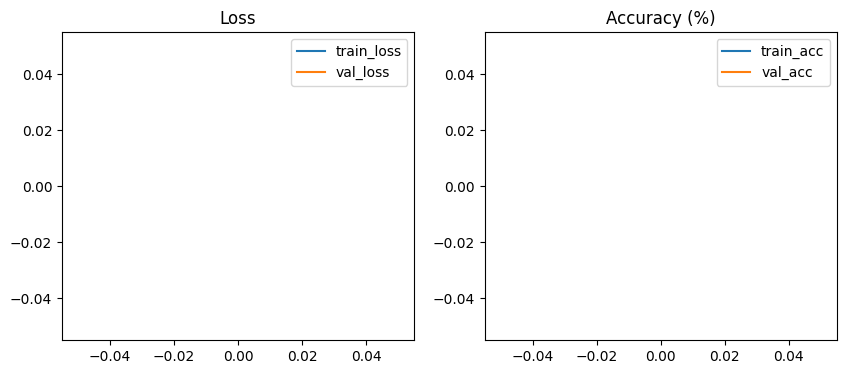

In [52]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Accuracy (%)")
plt.legend()
plt.show()

In [53]:
def evaluate(model, loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    preds_all = []
    labels_all = []
    criterion = nn.CrossEntropyLoss() # Assuming CrossEntropyLoss is used for evaluation

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = outputs.argmax(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    val_loss = running_loss / len(loader)
    val_acc = 100 * correct / total
    return val_loss, val_acc, preds_all, labels_all

In [66]:
# load best
#Check with test data on the best checkpoint
#ckpt = torch.load("best_resnet50.pth", map_location=device) # Use checkpoint_path instead
ckpt = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
# get predictions on val set
val_loss, val_acc, preds_all, labels_all = evaluate(model, val_loader, device)
print(f"Validation — loss: {val_loss:.4f}, acc: {val_acc:.2f}%")

Validation — loss: 0.1222, acc: 98.51%


In [56]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(labels_all, preds_all, target_names=classes))

              precision    recall  f1-score   support

    basophil       0.96      1.00      0.98       244
  eosinophil       1.00      1.00      1.00       653
erythroblast       0.99      0.99      0.99       282
          ig       0.97      0.95      0.96       578
  lymphocyte       0.99      0.99      0.99       267
    monocyte       0.96      0.99      0.98       278
  neutrophil       0.98      0.98      0.98       690
    platelet       1.00      1.00      1.00       426

    accuracy                           0.99      3418
   macro avg       0.98      0.99      0.98      3418
weighted avg       0.99      0.99      0.99      3418



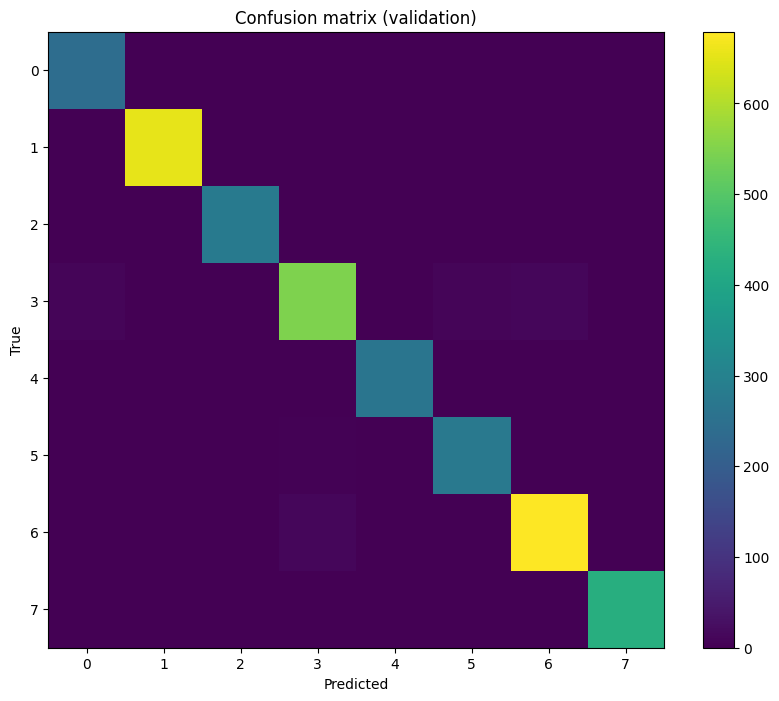

In [57]:
# confusion matrix (large; plot with imshow)
cm = confusion_matrix(labels_all, preds_all)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix (validation)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

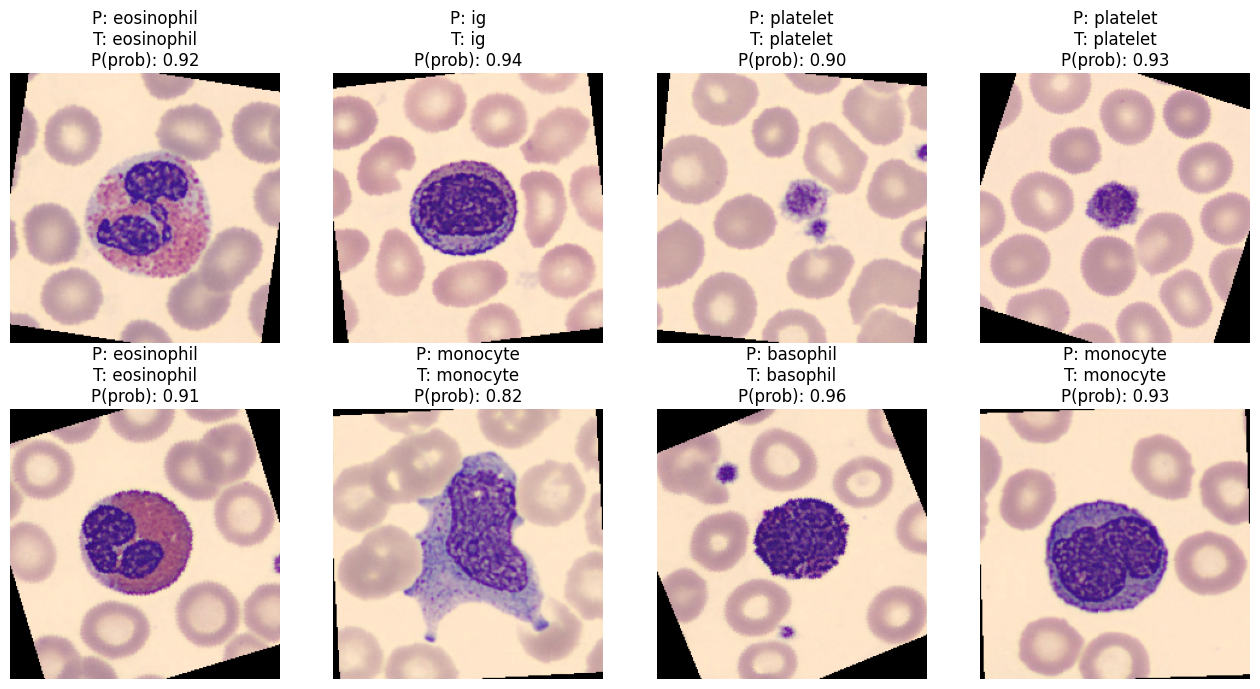

In [58]:
import torchvision
softmax = nn.Softmax(dim=1)

def show_predictions(model, loader, classes, device, n=8):
    model.eval()
    imgs_shown = 0
    plt.figure(figsize=(16,8))
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = softmax(outputs)
            preds = outputs.argmax(1)
            for i in range(images.size(0)):
                if imgs_shown >= n: break
                img = images[i].cpu()
                # undo normalization for plotting
                img = denormalize(img) # Use the existing denormalize function
                img = torchvision.transforms.functional.to_pil_image(img.clamp(0,1))
                plt.subplot(2, n//2, imgs_shown+1)
                plt.imshow(img)
                plt.title(f"P: {classes[preds[i]]}\nT: {classes[labels[i]]}\nP(prob): {probs[i,preds[i]].item():.2f}")
                plt.axis('off')
                imgs_shown += 1
            if imgs_shown >= n: break
    plt.show()

show_predictions(model, val_loader, classes, device, n=8)

# Sample

In [59]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader, Subset
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Step 1: Use pretrained ResNet-50 backbone
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze base layers for faster training
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last block for fine-tuning
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

    elif "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# Replace classifier head
num_classes = len(classes)
#model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, num_classes)
)

model = model.to(device)

In [60]:
# ✅ Step 2: Make a smaller, balanced subset to test pipeline
subset_indices = random.sample(range(len(data)), min(5000, len(data)))
subset = Subset(data, subset_indices)

train_loader = DataLoader(subset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

In [61]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [62]:
# ✅ Step 3: Define loss and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

#optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5,
    weight_decay=1e-4
)

In [63]:
from torch import amp
scaler = amp.GradScaler("cuda")

with amp.autocast("cuda"):
    outputs = model(images)
    loss = criterion(outputs, labels)

In [64]:
from torch.optim.lr_scheduler import CosineAnnealingLR

scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

In [65]:
# ✅ Step 4: Fast sanity training
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0


    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(train_loader):.4f} - Train Accuracy: {acc:.2f}%")

    scheduler.step()

print("complete — if accuracy >60%, your pipeline is solid.")

Epoch [1/10] - Loss: 1.1312 - Train Accuracy: 73.60%
Epoch [2/10] - Loss: 0.6724 - Train Accuracy: 93.12%
Epoch [3/10] - Loss: 0.6198 - Train Accuracy: 94.70%
Epoch [4/10] - Loss: 0.5940 - Train Accuracy: 96.24%
Epoch [5/10] - Loss: 0.5832 - Train Accuracy: 96.50%
Epoch [6/10] - Loss: 0.5729 - Train Accuracy: 97.00%
Epoch [7/10] - Loss: 0.5749 - Train Accuracy: 96.98%
Epoch [8/10] - Loss: 0.5752 - Train Accuracy: 96.84%
Epoch [9/10] - Loss: 0.5649 - Train Accuracy: 97.48%
Epoch [10/10] - Loss: 0.5567 - Train Accuracy: 97.54%
complete — if accuracy >60%, your pipeline is solid.


----------------------------------------------